In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.milp.milp_mcp_server import records_to_arrays, solve_daily_milp
from agentic_energy.data_loader import EnergyDataLoader, BatteryDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, EnergyDataRecord, SolveFromRecordsRequest

2025-10-16 20:19:34.783 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-16 20:19:34.784 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 20:19:34.784 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 20:19:34.784 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-16 20:19:34.793 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-16 20:19:34.794 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini', 'openai']. Using 'gemini'


In [2]:
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

2025-10-16 20:19:35.837 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_actual.csv


In [3]:
italy_data[0]

EnergyDataRecord(timestamps='2018-01-01 00:00:00', prices=45.82, consumption=22.98, year=None, region='ITALY', decisions=None)

In [4]:
stats= await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
print(stats.pretty_print())

Atype : <class 'agentic_energy.schemas.SummaryStats'>
region: ITALY
total_records: 17518
date_range:
  start: '2018-01-01 00:00:00'
  end: '2019-12-31 23:00:00'
prices:
  count: 17518
  min: 1.0
  max: 159.4
  avg: 56.81830574266469
  median: 55.99
  p25: 46.662499999999994
  p75: 66.13
  std: 14.514075376488504
  var: 210.6583840343899
consumption:
  count: 17518
  min: 18.85
  max: 50.31
  avg: 33.148212124671765
  median: 32.65
  p25: 26.96
  p75: 39.32
  std: 6.92811417513687
  var: 47.998766023732436




In [5]:
batt = BatteryDataLoader(
    load_stats={
        "p25":stats.states[0].consumption.p25,
        "p75":stats.states[0].consumption.p75
    },
    duration_hours=4,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c = 0.95,
    eta_d = 0.95,
    soc_target=0.5,
)
batterydetails = batt.compute_battery_params()
print(batt.summary())

{'Capacity (kWh)': 49.44, 'Charge Power (kW)': 12.36, 'Discharge Power (kW)': 12.36, 'Efficiency (Charge/Discharge)': (0.95, 0.95), 'Duration (hours)': 4}


In [6]:
# capacity = 1.0  # kWh
# batterydetails = BatteryParams(
#     capacity_kwh=capacity,   # 4-hour energy at 100 kW power: good for diurnal spreads
#     soc_init=0.50,        # neutral start
#     soc_min=0.0,         # keep 10% buffer for longevity + contingency
#     soc_max=1.0,         # avoid top-of-charge stress
#     cmax_kw=capacity/4,        # 4-hour duration (capacity/4)
#     dmax_kw=capacity/4,        # symmetric charge/discharge
#     eta_c=0.95,           # ~92% round-trip when paired with eta_d
#     eta_d=0.95,
#     soc_target=0.50       # keep headroom to buy when prices dip; adjust by time-of-day policy
# )

In [7]:
# now have a for loop to run milp on each day
result = []
day_info =[]
decision_list = []
soc_list =[]
for i in range(len(italy_data)//24):
    print(f"Solving day {i+1} of {len(italy_data)//24}")
    records = SolveFromRecordsRequest(
        battery=batterydetails,
        records=italy_data[i*24:(i+1)*24],
        dt_hours=1.0,
        allow_export=True,
        solver = None,
        solver_opts = None
    )

    prices, demand = records_to_arrays(records.records)
    day = DayInputs(
        prices_buy=prices,
        demand_kw=demand,
        prices_sell=prices,
        allow_export=records.allow_export,
        dt_hours=records.dt_hours
    )
    day_info.append(day)
    res = solve_daily_milp(records.battery, day, records.solver, records.solver_opts)
    result.append(res)
    decision_list+=res.decision
    batterydetails.soc_init=res.soc[-1]
    soc_list+=res.soc[:-1]


Solving day 1 of 729
Set parameter WLSAccessID


[10/16/25 20:19:36] INFO     Set parameter WLSAccessID                                           ]8;id=456046;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=527069;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter WLSSecret


                    INFO     Set parameter WLSSecret                                             ]8;id=946503;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=45546;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter LicenseID to value 2718037


                    INFO     Set parameter LicenseID to value 2718037                            ]8;id=924776;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=572862;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Academic license 2718037 - for non-commercial use only - registered to mi___@columbia.edu


                    INFO     Academic license 2718037 - for non-commercial use only - registered ]8;id=22097;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=945250;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\
                             to mi___@columbia.edu                                                                 

Solving day 2 of 729
Solving day 3 of 729
Solving day 4 of 729
Solving day 5 of 729
Solving day 6 of 729
Solving day 7 of 729
Solving day 8 of 729
Solving day 5 of 729
Solving day 6 of 729
Solving day 7 of 729
Solving day 8 of 729
Solving day 9 of 729
Solving day 10 of 729
Solving day 11 of 729
Solving day 9 of 729
Solving day 10 of 729
Solving day 11 of 729
Solving day 12 of 729
Solving day 13 of 729
Solving day 14 of 729
Solving day 15 of 729
Solving day 12 of 729
Solving day 13 of 729
Solving day 14 of 729
Solving day 15 of 729
Solving day 16 of 729
Solving day 17 of 729
Solving day 18 of 729
Solving day 19 of 729
Solving day 16 of 729
Solving day 17 of 729
Solving day 18 of 729
Solving day 19 of 729
Solving day 20 of 729
Solving day 21 of 729
Solving day 22 of 729
Solving day 23 of 729
Solving day 20 of 729
Solving day 21 of 729
Solving day 22 of 729
Solving day 23 of 729
Solving day 24 of 729
Solving day 25 of 729
Solving day 26 of 729
Solving day 24 of 729
Solving day 25 of 729
S

In [8]:
len(result)

729

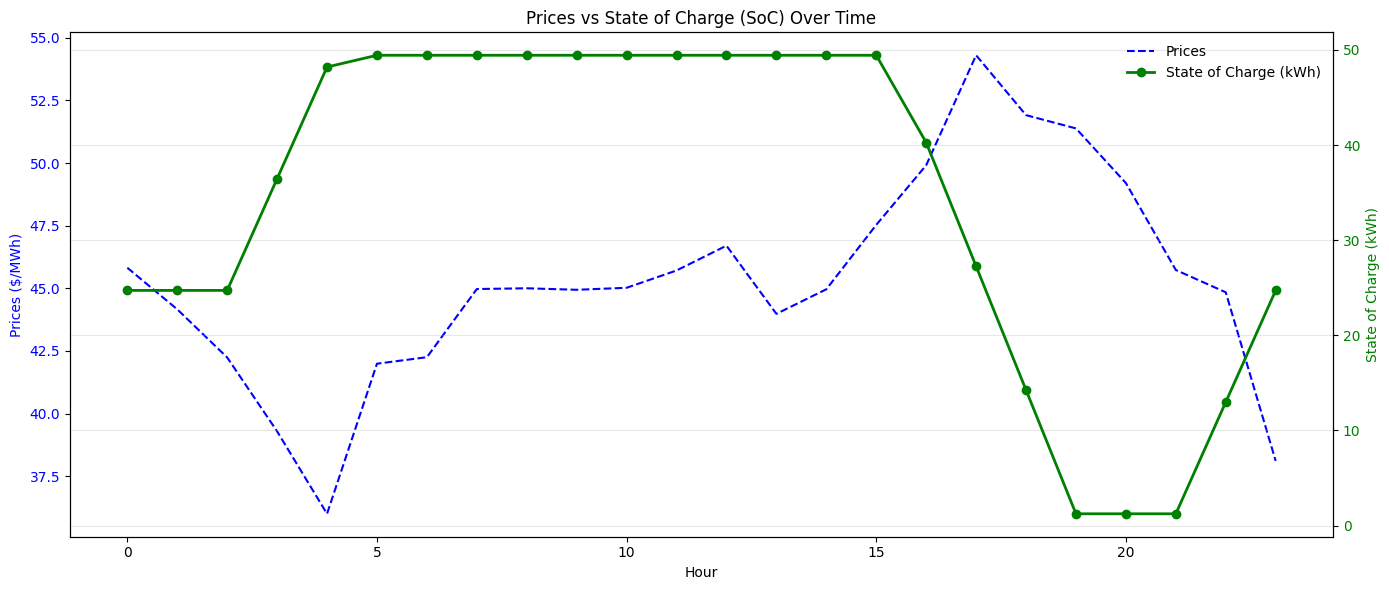

In [9]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(result[0].soc[1:]) * batterydetails.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


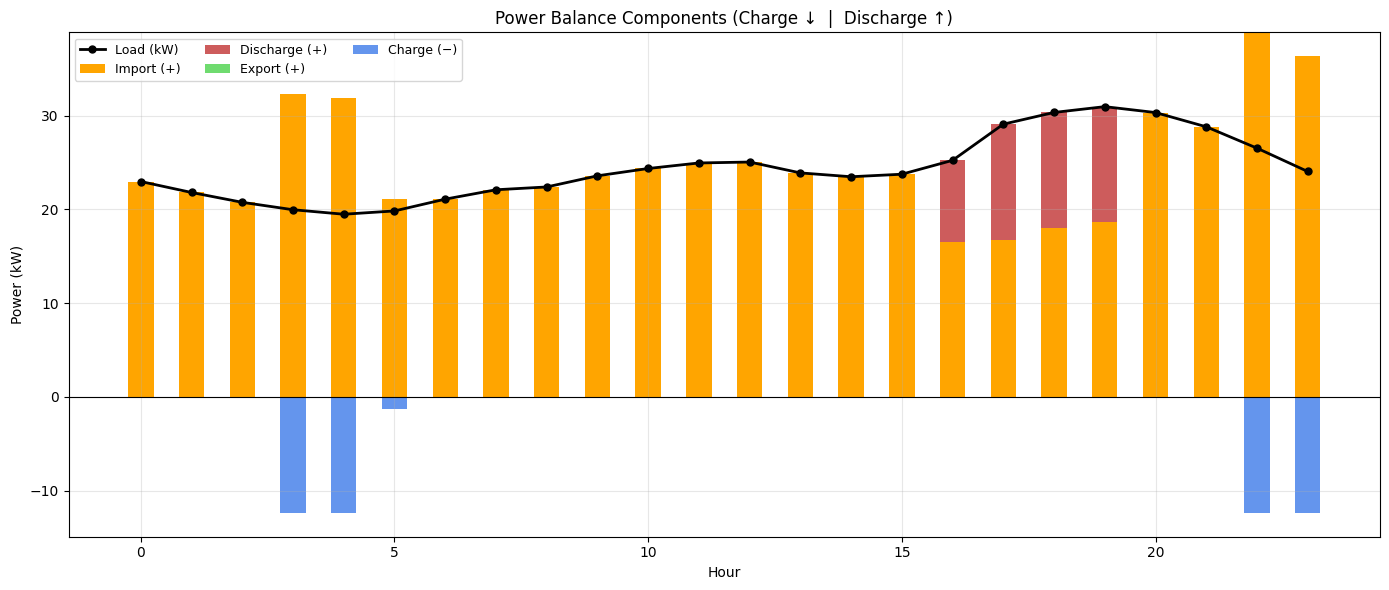

In [10]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info[0].demand_kw)
charge = np.array(result[0].charge_kw)
discharge = np.array(result[0].discharge_kw)
import_kw = np.array(result[0].import_kw)
export_kw = np.array(result[0].export_kw) if getattr(day_info[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
total_objective_value = 0
for day_result in result:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len(result)} days")

Total Objective Value over all days: $33284037.05 for 729 days


In [21]:
result[0].objective_cost

26362.261941999997

In [12]:
# profit = day_info[0].prices_buy*discharge - day_info[0].prices_buy*charge
# print(profit.sum())

In [13]:
# len(decision_list)

In [14]:
# import pandas as pd
# italy_data = pd.read_csv("agentic_energy/data/ITALY_data.csv")
# italy_data.head()

In [15]:
# italy_data.shape

In [16]:
# 17496+24, 17496/24, len(soc_list)

In [17]:
# italy_data=italy_data.iloc[:len(decision_list)]
# soc_list = soc_list[:len(decision_list)]

In [18]:
# # I want to fill the decisions column in such a way that if soc_t > soc_t-1 then decision = 1 (charging)
# # if soc_t < soc_t-1 then decision = -1 (discharging)
# # if soc_t == soc_t-1 then decision = 0 (idle)
# italy_data["soc"] = soc_list
# italy_data['soc_prev'] = italy_data['soc'].shift(1)
# italy_data['decisions'] = 0  # Initialize with 0 (idle)
# italy_data.loc[italy_data['soc'] > italy_data['soc_prev'], 'decisions'] = 1   # Charging
# italy_data.loc[italy_data['soc'] < italy_data['soc_prev'], 'decisions'] = -1  # Discharging
# italy_data.loc[italy_data['soc'] == italy_data['soc_prev'], 'decisions'] = 0   # Idle



In [19]:
# italy_data.head()

In [20]:
# italy_data.to_csv("agentic_energy/data/ITALY_data_with_decisions.csv", index=False)